In [1]:
dir_data = "dataset1/"
dir_seg = dir_data + "/annotations_prepped_train/"
dir_img = dir_data + "/images_prepped_train/"

0001TP_006690.png
seg.shape=(360, 480, 3), img_is.shape=(360, 480, 3)
minimum seg = 0, maximum seg = 11, Total number of segmentation classes = 12


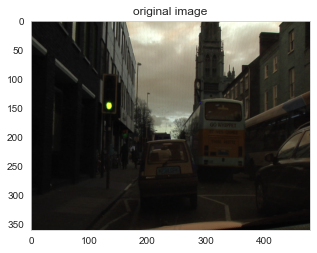

<ipython-input-2-45e931c4080d>:32: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(3,n_classes/3,k+1)


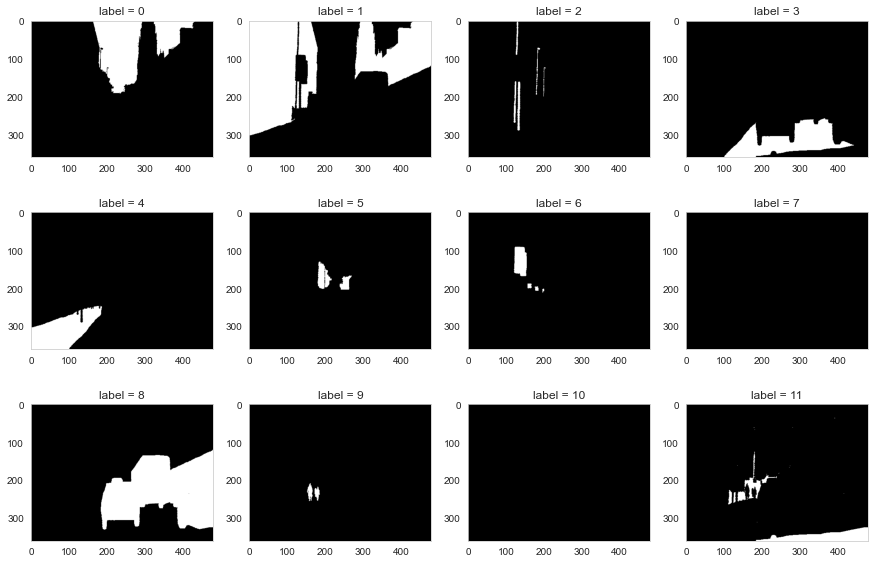

In [2]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## seaborn has white grid by default so I will get rid of this.
sns.set_style("whitegrid", {'axes.grid' : False})


ldseg = np.array(os.listdir(dir_seg))
## pick the first image file
fnm = ldseg[0]
print(fnm)

## read in the original image and segmentation labels
seg = cv2.imread(dir_seg + fnm ) # (360, 480, 3)
img_is = cv2.imread(dir_img + fnm )
print("seg.shape={}, img_is.shape={}".format(seg.shape,img_is.shape))

## Check the number of labels
mi, ma = np.min(seg), np.max(seg)
n_classes = ma - mi + 1
print("minimum seg = {}, maximum seg = {}, Total number of segmentation classes = {}".format(mi,ma, n_classes))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.imshow(img_is)
ax.set_title("original image")
plt.show()

fig = plt.figure(figsize=(15,10))
for k in range(mi,ma+1):
    ax = fig.add_subplot(3,n_classes/3,k+1)
    ax.imshow((seg == k)*1.0)
    ax.set_title("label = {}".format(k))


plt.show()

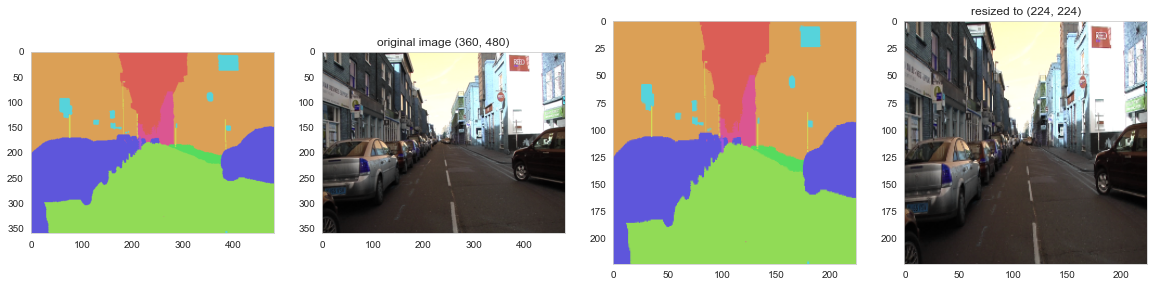

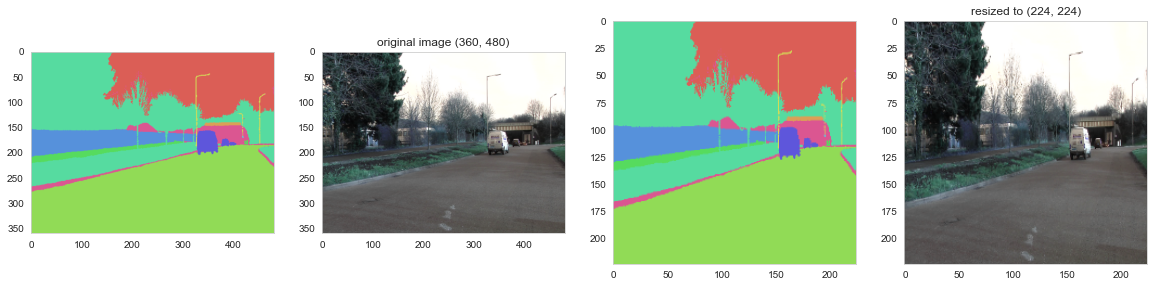

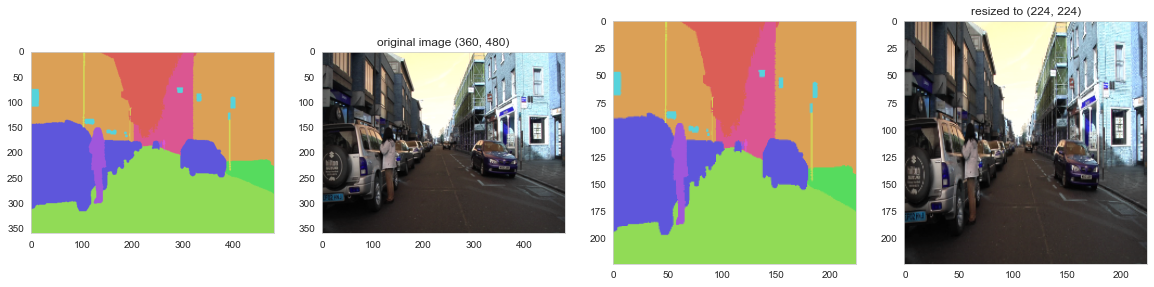

In [3]:
import random
def give_color_to_seg_img(seg,n_classes):
    '''
    seg : (input_width,input_height,3)
    '''
    
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

input_height , input_width = 224 , 224
output_height , output_width = 224 , 224


ldseg = np.array(os.listdir(dir_seg))
for fnm in ldseg[np.random.choice(len(ldseg),3,replace=False)]:
    fnm = fnm.split(".")[0]
    seg = cv2.imread(dir_seg + fnm + ".png") # (360, 480, 3)
    img_is = cv2.imread(dir_img + fnm + ".png")
    seg_img = give_color_to_seg_img(seg,n_classes)

    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,4,1)
    ax.imshow(seg_img)
    
    ax = fig.add_subplot(1,4,2)
    ax.imshow(img_is/255.0)
    ax.set_title("original image {}".format(img_is.shape[:2]))
    
    ax = fig.add_subplot(1,4,3)
    ax.imshow(cv2.resize(seg_img,(input_height , input_width)))
    
    ax = fig.add_subplot(1,4,4)
    ax.imshow(cv2.resize(img_is,(output_height , output_width))/255.0)
    ax.set_title("resized to {}".format((output_height , output_width)))
    plt.show()

In [4]:
def getImageArr( path , width , height ):
        img = cv2.imread(path, 1)
        img = np.float32(cv2.resize(img, ( width , height ))) / 127.5 - 1
        return img

def getSegmentationArr( path , nClasses ,  width , height  ):

    seg_labels = np.zeros((  height , width  , nClasses ))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, ( width , height ))
    img = img[:, : , 0]

    for c in range(nClasses):
        seg_labels[: , : , c ] = (img == c ).astype(int)
    ##seg_labels = np.reshape(seg_labels, ( width*height,nClasses  ))
    return seg_labels




images = os.listdir(dir_img)
images.sort()
segmentations  = os.listdir(dir_seg)
segmentations.sort()
    
X = []
Y = []
for im , seg in zip(images,segmentations) :
    X.append( getImageArr(dir_img + im , input_width , input_height )  )
    Y.append( getSegmentationArr( dir_seg + seg , n_classes , output_width , output_height )  )

X, Y = np.array(X) , np.array(Y)
print(X.shape,Y.shape)

(367, 224, 224, 3) (367, 224, 224, 12)


In [5]:
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow import keras 
import sys, time, warnings
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import pandas as pd 
warnings.filterwarnings("ignore")

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "2" 
set_session(tf.compat.v1.Session(config=config))   

print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

python 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
keras version 2.5.0
tensorflow version 2.5.2


In [6]:
## location of VGG weights
VGG_Weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [7]:
def FCN8( nClasses ,  input_height=224, input_width=224):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller
    assert input_height%32 == 0
    assert input_width%32 == 0
    IMAGE_ORDERING =  "channels_last" 

    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
    
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)## (None, 14, 14, 512) 

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)## (None, 7, 7, 512)

    #x = Flatten(name='flatten')(x)
    #x = Dense(4096, activation='relu', name='fc1')(x)
    # <--> o = ( Conv2D( 4096 , ( 7 , 7 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
    
    #x = Dense(4096, activation='relu', name='fc2')(x)
    # <--> o = ( Conv2D( 4096 , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)   
    # assuming that the input_height = input_width = 224 as in VGG data
    
    #x = Dense(1000 , activation='softmax', name='predictions')(x)
    # <--> o = ( Conv2D( nClasses ,  ( 1 , 1 ) ,kernel_initializer='he_normal' , data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
    
    
    vgg  = Model(  img_input , pool5  )
    vgg.load_weights(VGG_Weights_path) ## loading VGG weights for the encoder parts of FCN8
    
    n = 4096
    o = ( Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING))(pool5)
    conv7 = ( Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING))(o)
    
    
    ## 4 times upsamping for pool4 layer
    conv7_4 = Conv2DTranspose( nClasses , kernel_size=(4,4) ,  strides=(4,4) , use_bias=False, data_format=IMAGE_ORDERING )(conv7)
    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
    pool411_2 = (Conv2DTranspose( nClasses , kernel_size=(2,2) ,  strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING ))(pool411)
    
    pool311 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool3_11", data_format=IMAGE_ORDERING))(pool3)
        
    o = Add(name="add")([pool411_2, pool311, conv7_4 ])
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False, data_format=IMAGE_ORDERING )(o)
    o = (Activation('softmax'))(o)
    
    model = Model(img_input, o)

    return model

model = FCN8(nClasses     = n_classes,  
             input_height = 224, 
             input_width  = 224)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [8]:
from sklearn.utils import shuffle
train_rate = 0.85
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(311, 224, 224, 3) (311, 224, 224, 12)
(56, 224, 224, 3) (56, 224, 224, 12)


In [9]:
from tensorflow.keras import optimizers


sgd = optimizers.SGD(lr=1e-2, decay=5**(-4), momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

hist1 = model.fit(X_train,y_train,
                  validation_data=(X_test,y_test),
                  batch_size=32,epochs=75,verbose=2)

Epoch 1/75
10/10 - 496s - loss: 2.5849 - accuracy: 0.0842 - val_loss: 2.4848 - val_accuracy: 0.0855
Epoch 2/75
10/10 - 468s - loss: 2.4844 - accuracy: 0.0864 - val_loss: 2.4838 - val_accuracy: 0.0875
Epoch 3/75
10/10 - 314s - loss: 2.4833 - accuracy: 0.0894 - val_loss: 2.4825 - val_accuracy: 0.0923
Epoch 4/75
10/10 - 321s - loss: 2.4814 - accuracy: 0.0950 - val_loss: 2.4803 - val_accuracy: 0.0987
Epoch 5/75
10/10 - 315s - loss: 2.4787 - accuracy: 0.1025 - val_loss: 2.4769 - val_accuracy: 0.1059
Epoch 6/75
10/10 - 321s - loss: 2.4739 - accuracy: 0.1098 - val_loss: 2.4707 - val_accuracy: 0.1122
Epoch 7/75
10/10 - 326s - loss: 2.4647 - accuracy: 0.1180 - val_loss: 2.4579 - val_accuracy: 0.1225
Epoch 8/75
10/10 - 349s - loss: 2.4436 - accuracy: 0.1323 - val_loss: 2.4260 - val_accuracy: 0.1439
Epoch 9/75
10/10 - 346s - loss: 2.3842 - accuracy: 0.1656 - val_loss: 2.3240 - val_accuracy: 0.1960
Epoch 10/75
10/10 - 344s - loss: 2.2384 - accuracy: 0.2547 - val_loss: 2.3245 - val_accuracy: 0.2806

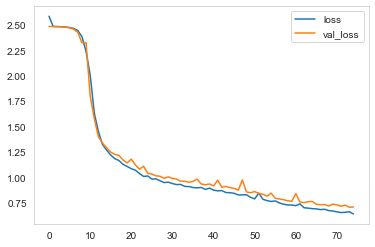

In [10]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()

In [11]:
y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)
print(y_testi.shape,y_predi.shape)

(56, 224, 224) (56, 224, 224)


In [12]:
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))
    
IoU(y_testi,y_predi)

class 00: #TP=411336, #FP= 41072, #FN=34423, IoU=0.845
class 01: #TP=638149, #FP=220707, #FN=54229, IoU=0.699
class 02: #TP=    18, #FP=   250, #FN=33673, IoU=0.001
class 03: #TP=792188, #FP= 65302, #FN=46639, IoU=0.876
class 04: #TP= 59378, #FP= 42416, #FN=78731, IoU=0.329
class 05: #TP=208843, #FP= 80658, #FN=72065, IoU=0.578
class 06: #TP=    90, #FP=   566, #FN=34233, IoU=0.003
class 07: #TP=   252, #FP=  1049, #FN=35095, IoU=0.007
class 08: #TP=106937, #FP=105212, #FN=65263, IoU=0.385
class 09: #TP=     7, #FP=   315, #FN=22724, IoU=0.000
class 10: #TP=     0, #FP=    95, #FN=18524, IoU=0.000
class 11: #TP= 24733, #FP= 10283, #FN=72326, IoU=0.230
_________________
Mean IoU: 0.329


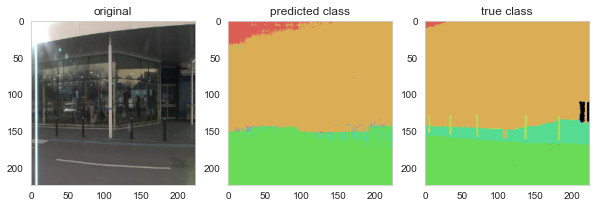

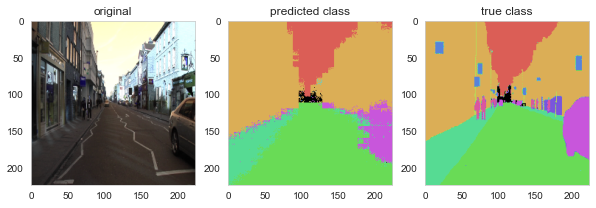

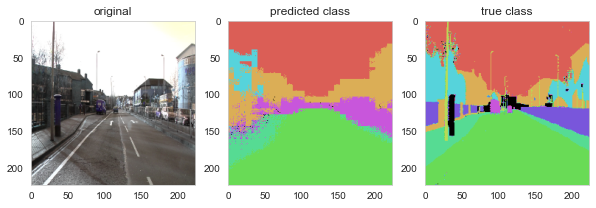

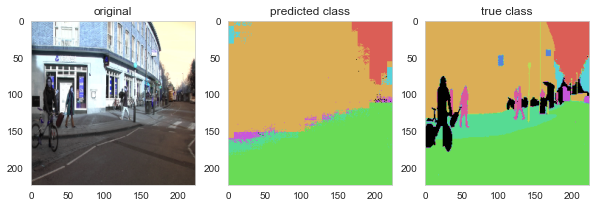

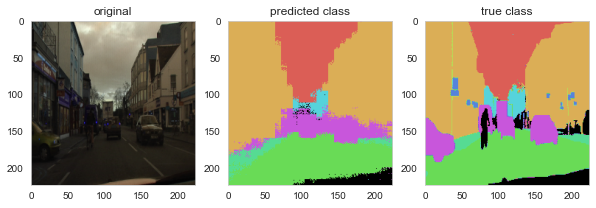

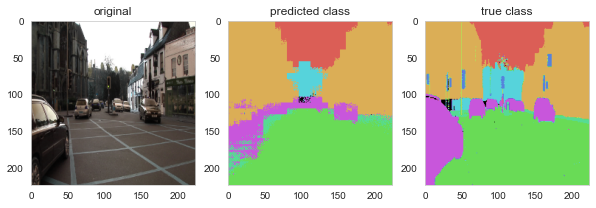

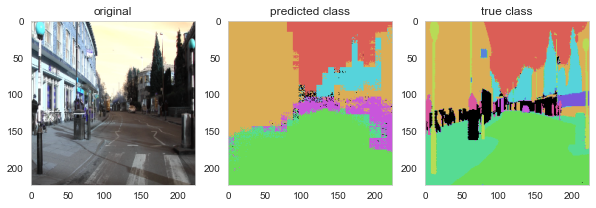

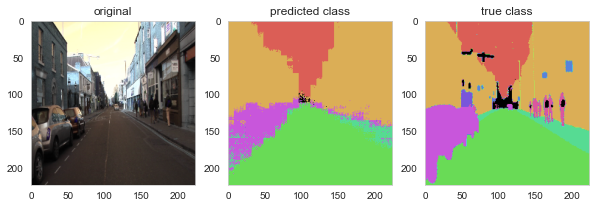

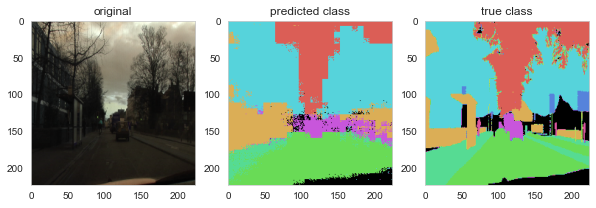

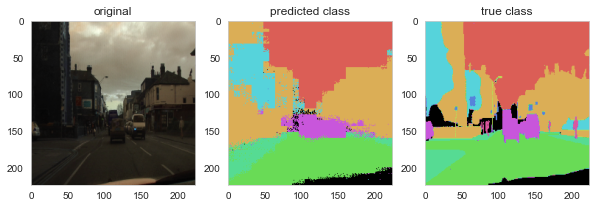

In [14]:
shape = (224,224)
n_classes= 10

for i in range(10):
    img_is  = (X_test[i] + 1)*(255.0/2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(10,30))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(give_color_to_seg_img(seg,n_classes))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(give_color_to_seg_img(segtest,n_classes))
    ax.set_title("true class")
    plt.show()